In [1]:
import pandas as pd
import numpy as np

dataset_path = "datasets/Polyvore"

In [2]:
fashion_df = pd.read_csv(dataset_path+"/fashion_compatibility_prediction.txt",
                             sep=' ',
                             header=None,
                              names=['label','item_1','item_2','item_3','item_4','item_5','item_6','item_7','item_8'],
                            keep_default_na=False)

FileNotFoundError: [Errno 2] File b'datasets/Polyvore/fashion_compatibility_prediction.txt' does not exist: b'datasets/Polyvore/fashion_compatibility_prediction.txt'

In [280]:
fashion_df.head()

,label,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8
0,1,119704139_1,119704139_2,119704139_3,119704139_4,119704139_5,,,
1,1,119314458_1,119314458_2,119314458_3,119314458_4,119314458_5,119314458_6,119314458_7,119314458_8
2,1,147361785_1,147361785_2,147361785_3,147361785_4,147361785_5,147361785_6,,
3,1,148015877_1,148015877_2,148015877_3,148015877_4,,,,
4,1,192637078_1,192637078_2,192637078_3,192637078_4,192637078_5,192637078_6,192637078_7,192637078_8


In [7]:
print("Size:", fashion_df.shape[0])

Size: 7076


In [8]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def getImagePath(image_name):
    if image_name != '':
        name = image_name.split("_")
        return dataset_path + "/images/"+name[0]+"/"+name[1]+".jpg"
    else:
        return ''

In [337]:
def loadImage(image_path):
    #print(image_path)
    if image_path != '':
        bgr_img = cv2.imread(image_path)
        bgr_img = cv2.resize(bgr_img, (400,400))
    else:
        bgr_img = np.zeros((400,400, 3), dtype="uint8")
    return bgr_img

In [11]:
def showOutfit(outfit):
    count = 0
    items = list()
    for item in outfit:
        if item != '':
            count += 1
            item_path = getImagePath(item)
            items.append(item_path)
    fig = plt.figure(figsize=(20,20))
    for i in range(count):
        ax = fig.add_subplot(1,count, i+1, xticks=[], yticks=[])
        image = loadImage(items[i])
        print('Image size:', image.shape)
        ax.imshow(image)
        ax.set_title('item %s' % (i+1))

In [12]:
print("Image:",fashion_df.iloc[1,2])
print("at:", getImagePath(fashion_df.iloc[1,2]))

Image: 119314458_2
at: datasets/Polyvore/images/119314458/2.jpg


Image size: (400, 400, 3)
Image size: (400, 400, 3)
Image size: (400, 400, 3)
Image size: (400, 400, 3)


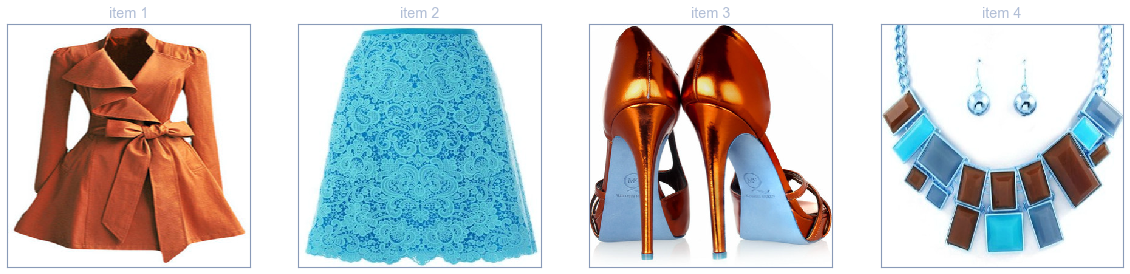

In [339]:
showOutfit(fashion_df.iloc[1, 1:5])

In [319]:
from sklearn.model_selection import train_test_split

fashion_df = fashion_df[0:500]

X_train, X_test, y_train, y_test = train_test_split( 
    fashion_df.iloc[:, 1 : 5], 
    fashion_df.iloc[:, 0], test_size=0.20,
    random_state=42)

X_train = X_train[0:500]
y_train = y_train[0:500]

In [320]:
X_train_images = X_train.applymap(getImagePath)
X_train_images = X_train_images.applymap(loadImage)
X_train_images = np.array(X_train_images)
X_train_images = X_train_images / 255.0

X_test_images = X_test.applymap(getImagePath)
X_test_images = X_test_images.applymap(loadImage)
X_test_images = np.array(X_test_images)
X_test_images = X_test_images / 255.0

In [294]:
def unwrapArray(array, new_shape):
    unwrapped_array = np.zeros(new_shape)
    for i in range(array.shape[0]):
        for j in range(array[0].shape[0]):
            unwrapped_array[i,j,:,:,:] = array[i,j]
    return unwrapped_array

In [321]:
x_train_array = unwrapArray(X_train_images, (X_train_images.shape[0],X_train_images.shape[1],64,64,3))
x_test_array = unwrapArray(X_test_images, (X_test_images.shape[0],X_test_images.shape[1],64,64,3))

In [322]:
x_train_array.shape

(400, 4, 64, 64, 3)

In [323]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [324]:
x_train_array = x_train_array.transpose(1,0,2,3,4)
x_test_array = x_test_array.transpose(1,0,2,3,4)

In [325]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
np.random.seed(1000)

In [326]:
def build_cnn():
    image = Input(shape=(64,64,3))
    
    chanDim = -1
    
    x = Conv2D(16, (3, 3), padding="same")(image)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(32, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
    
    model = Model(inputs = image, outputs = x)
    return model

In [327]:
model_1 = build_cnn()
model_2 = build_cnn()
model_3 = build_cnn()
model_4 = build_cnn()

combinedInput = concatenate([model_1.output, model_2.output, model_3.output, model_4.output])

x = Dense(128, activation="relu")(combinedInput)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
x = Dense(1, activation="sigmoid")(x)

model = Model(inputs=[model_1.input, model_2.input, model_3.input, model_4.input], outputs=x)

In [328]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [329]:
model.summary()

Model: "model_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 64, 64, 3)]  0                                            
___________________________________________________________________________________________

In [330]:
model.fit(
    [x_train_array[0], x_train_array[1], x_train_array[2], x_train_array[3]], y_train,
    epochs=10, validation_split=0.1)

Train on 360 samples, validate on 40 samples
Epoch 1/10
360/360 [==============================] - 12s 34ms/sample - loss: 0.3845 - accuracy: 0.8694 - val_loss: 0.2902 - val_accuracy: 1.0000
Epoch 2/10
360/360 [==============================] - 6s 18ms/sample - loss: 0.0356 - accuracy: 1.0000 - val_loss: 0.1026 - val_accuracy: 1.0000
Epoch 3/10
360/360 [==============================] - 7s 19ms/sample - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.0596 - val_accuracy: 1.0000
Epoch 4/10
360/360 [==============================] - 7s 21ms/sample - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0398 - val_accuracy: 1.0000
Epoch 5/10
360/360 [==============================] - 8s 21ms/sample - loss: 7.4846e-04 - accuracy: 1.0000 - val_loss: 0.0285 - val_accuracy: 1.0000
Epoch 6/10
360/360 [==============================] - 8s 21ms/sample - loss: 6.0592e-04 - accuracy: 1.0000 - val_loss: 0.0198 - val_accuracy: 1.0000
Epoch 7/10
360/360 [==============================] - 8s 21ms/sample - loss:

In [331]:
loss, accuracy = model.evaluate([x_test_array[0],x_test_array[1],x_test_array[2],x_test_array[3]], y_test, verbose = False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  1.0000


In [332]:
model.save_weights('prototype_cnn.h5')

In [333]:
model.predict([x_test_array[0],x_test_array[1],x_test_array[2],x_test_array[3]])

array([[0.9979888 ],
       [0.996918  ],
       [0.9947199 ],
       [0.9969567 ],
       [0.99414283],
       [0.9974643 ],
       [0.9984291 ],
       [0.99277365],
       [0.9969232 ],
       [0.9979675 ],
       [0.99952495],
       [0.9955018 ],
       [0.9949012 ],
       [0.99696577],
       [0.9957316 ],
       [0.9967158 ],
       [0.9976051 ],
       [0.99487185],
       [0.9972948 ],
       [0.99386525],
       [0.9980604 ],
       [0.99437463],
       [0.99694186],
       [0.9980863 ],
       [0.99690676],
       [0.9984993 ],
       [0.9979801 ],
       [0.99751043],
       [0.998079  ],
       [0.99838495],
       [0.99732804],
       [0.9965428 ],
       [0.99782884],
       [0.9956844 ],
       [0.9975157 ],
       [0.9965832 ],
       [0.9989413 ],
       [0.99691015],
       [0.9962466 ],
       [0.99906945],
       [0.99424034],
       [0.99674696],
       [0.99733317],
       [0.9968511 ],
       [0.99823785],
       [0.9968817 ],
       [0.99555504],
       [0.995